# Salt Identification Challenge
## Capstone Project
Shane Moloney  
Udacity Machine Learning Nanodegree

## Set up

Imports for all the project dependencies.
I may split this so that the dependencies are in the relevant code cells to avoid needing to run this every time.

In [1]:
import numpy as np
import pandas as pd
import math

from random import randint

import cv2
from pprint import pprint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

from tqdm import tqdm_notebook

/Users/smoloney/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load in a Sample of the data

Let's have a look at the data to see what will need to be done to prepare it for learning.

In [3]:
train_samp = pd.read_csv("data/train/train.csv", index_col="id", nrows=5)
depths_samp = pd.read_csv("data/depths.csv", index_col="id", nrows=5)
print(train_samp)
print(depths_samp)

                                                     rle_mask
id                                                           
575d24d81d                                                NaN
a266a2a9df                                          5051 5151
75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...
34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...
              z
id             
4ac19fb269  306
1825fadf99  157
f59821d067  305
5b435fad9d  503
e340e7bfca  783


Above we can see the run-length encoded masks and the depths of the first five images.  

As we can see, images with no salt deposits have a null value and images with deposits have the pixels listed as ranges that cantain salt.  

Now we will look at the images themselves along with their provided masks as these are kindly provided to us in png form although they could also be extracted from the train.csv file by decoding the entries in the file.

Image Dimensions: (101, 101)


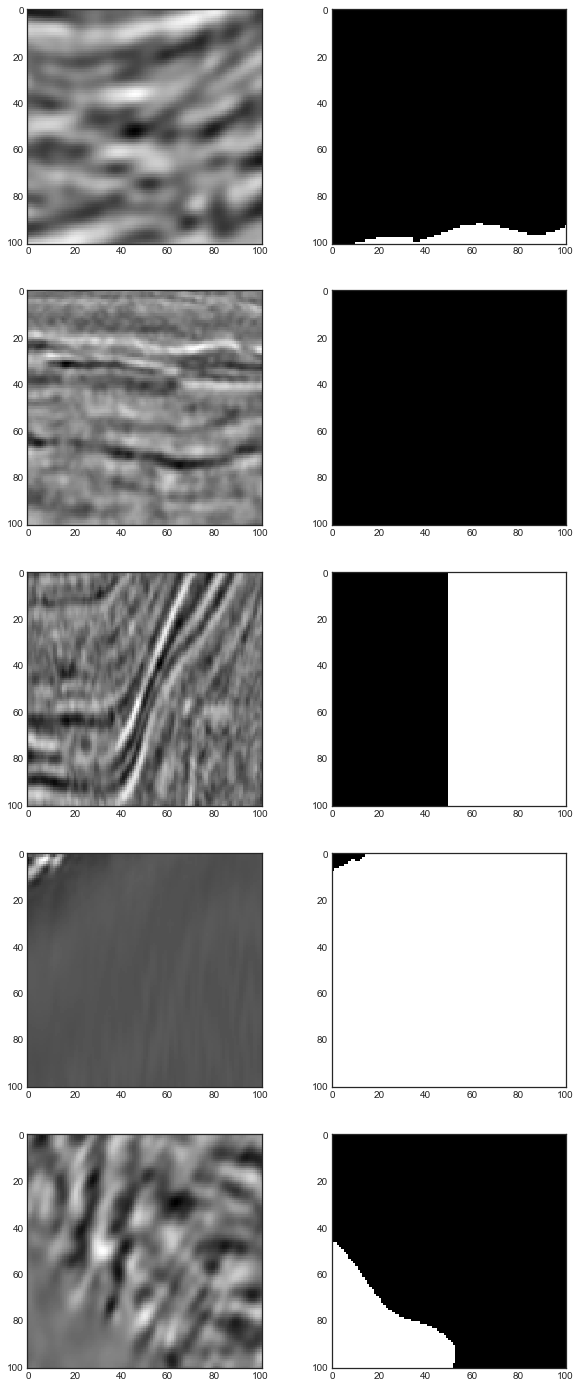

In [4]:
train_inds = train_samp.index

image_samp = [np.array(load_img("data/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in train_inds]
mask_samp = [np.array(load_img("data/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in train_inds]
image_size = image_samp[0].shape
print("Image Dimensions: {}".format(image_size))

fig, axs = plt.subplots(5, 2, figsize=(10, 25))
for i in range(0, 5):
    axs[int(i)][0].imshow(image_samp[i-1], cmap='gray')
    axs[int(i)][1].imshow(mask_samp[i-1], cmap='gray')
plt.show()


We can see that some masks may not be accurate as in the figure above the mask seems to claim that the salt deposit takes up exactly half the image with a perfectly straight border, which we can clearly see is incorrect.  

I may decide to remove any data whose mask matches this pattern.  

For now lets load in all the data and start looking at it as a whole.

## Loading in the Data

First we'll import the CSV files and add the depths as well and store a list of the indeces and a list of the test set depths, ie the depths whose ID's do not appear in the test set.

In [5]:
train_full = pd.read_csv("data/train/train.csv", index_col="id", usecols=[0])
depths = pd.read_csv("data/depths.csv", index_col="id")

train_full = train_full.join(depths)
train_idx = train_full.index

test_depths = depths[~depths.index.isin(train_full.index)]



Now we import the image and mask files, 4000 in total.

In [6]:
train_full["images"] = [np.array(load_img("data/train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_idx)]

HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))

In [7]:
train_full["masks"] = [np.array(load_img("data/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_idx)]

HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))

Create a column in the array for the coverage of the salt in each image. This means the number of pixels xcontaining salt over the area of the image. As this can be any decimal between 0 and 1 we discretise these values with the cov_to_class function which gives it an integer class from 1 to 10 which represent no salt up to only salt respectively.

In [8]:
train_full["coverage"] = train_full.masks.map(np.sum) / pow(image_size[0], 2)

In [9]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_full["coverage_class"] = train_full.coverage.map(cov_to_class)

Text(0.5,0,'Coverage class')

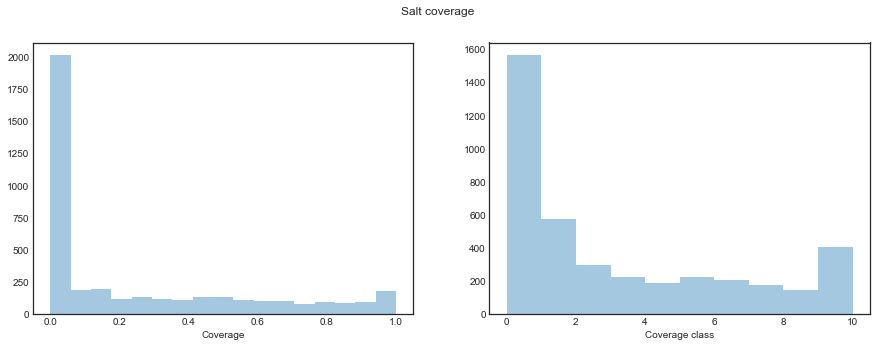

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_full.coverage, kde=False, ax=axs[0])
sns.distplot(train_full.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

We can see that a large amount of the images have no or very little salt, half the data set resides in classes 1 and 2. This is good as the model needs to know that there are images without salt as well.

## Depths
Now let's have a look at the depths and how good their random sampling was.

Text(0.5,1,'Depth distribution')

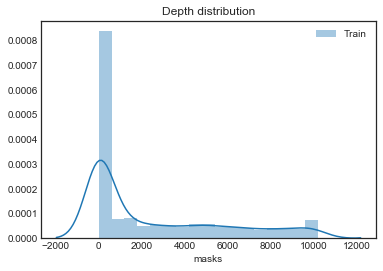

In [22]:
sns.distplot(train_full., label="Train")
plt.legend()
plt.title("Depth distribution")

A nice gaussian distribution was produced on both the train and testing sets which means we'll get a good range of different sediment layers.

## Preprocessing

First I'm, going to set the masks to all black for any that have perfectly straight borders as these are definitely not accurate and rather than remove them I will simply set them to a no salt state.

In [23]:
# I use opencv to edge detect the masks
# As the images are segmented by row I rotate the edge image
# I check if the row is entirely filled with an edge meaning a perfectly straight edge
def has_straight_border(mask_id, shape, edge_array):
    mask = cv2.imread('data/train/masks/{}.png'.format(mask_id))
    edges = cv2.Canny(mask, 100, 200)
    mat = cv2.getRotationMatrix2D((shape[0]/2,shape[1]/2),90,1)
    edges_rotated = cv2.warpAffine(edges, mat, shape)
    edge_array.append(edges_rotated)
    for row in edges_rotated:
        if all(pix == 255 for pix in row):
            return True
    return False

# Now find the list of straight edged masks
removed = []
edges = []
for idx in train_idx:
    if has_straight_border(idx, image_size, edges):
        removed.append(idx)

Now I'll have a look at the resulting masks and see if they make sense to remove.
I'll do this by overlaying the masks onto the images, where the salt is in green and the other sediment is in grey.

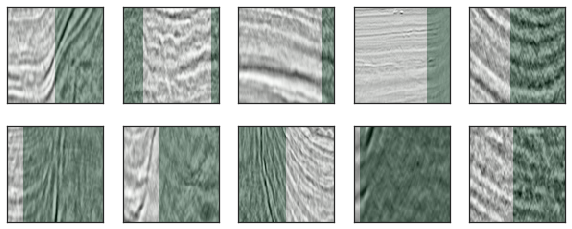

In [24]:
max_images = 10
grid_width = 5
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*2, grid_height*2))
for i, idx in enumerate(removed[:max_images]):
    mask = train_full.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(train_full.images[np.where(train_idx == idx)[0][0]], cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.set_yticklabels([])
    ax.set_xticklabels([])

There are 90 masks with perfectly straight borders, some ofe which look to be just inaccurate labelling, others seem to be mostly salt with colums of sediment. I don't want to lose the latter information as we saw in the coverage graph many of the images are quite low salt coverage. To remedy this I am going to keep any data points with a coverage class of 8 and above and drop the rest so as to avoid innaccurate border definition in the model.

In [416]:
for idx in removed:
    if train_full.coverage_class[idx] > 8:
        removed.remove(idx)
        
print("{} rows to be removed:".format(len(removed)))
pprint(removed)

27 rows to be removed:
['849881c690',
 'ba1287cb48',
 'aeba5383e4',
 'caccd6708f',
 '09152018c4',
 '23afbccfb5',
 'd9a52dc263',
 '39cd06da7d',
 '1eaf42beee',
 'e73ed6e7f2',
 '0b45bde756',
 '4f5df40ab2',
 'f19b7d20bb',
 'e6e3e58c43',
 '5b217529e7',
 '33dfce3a76',
 '834861f1b6',
 '7b5d5d40fe',
 '81fa3d59b8',
 '608567ed23',
 '916aff36ae',
 '00950d1627',
 'febd1d2a67',
 '403cb8f4b3',
 '93a1541218',
 'de7202d286',
 '49336bb17b']


In [417]:
train_full = train_full.drop(removed)
train_idx = train_full.index
print("New Data Shape: {}".format(train_full.shape))

New Data Shape: (3973, 5)


## Creating the Training and Validation Sets
I'll use the coverage class attribute as a stratification criterion to allow for even distribution in both sets.  

First we'll need a function to resize images to be an exponentially divisible number for the Unet model.
As well as a function for returning the images back to their original size.

In [423]:
new_size = 128

# Resizes the image to a square with sides the equal to the size provided
def upsample(img):
    if img.shape[0] == new_size:
        return img
    return resize(img, (new_size, new_size), mode='constant', preserve_range=True)

# Will need to return images to their original size for post processing
def downsample(img):
    if img.shape[0] == image_size[0]:
        return img
    return resize(img, image_size, mode='constant', preserve_range=True)

In [424]:
train_id, val_id, train_x, val_x, train_y, val_y, train_cov, test_cov, train_depth, test_depth = train_test_split(
    train_idx,
    np.array(train_full.images.map(upsample).tolist()).reshape(-1, new_size, new_size, 1), 
    np.array(train_full.masks.map(upsample).tolist()).reshape(-1, new_size, new_size, 1), 
    train_full.coverage.values,
    train_full.z.values,
    test_size=0.2, stratify=train_full.coverage_class, random_state=117)

Text(0.5,1,'Scaled image')

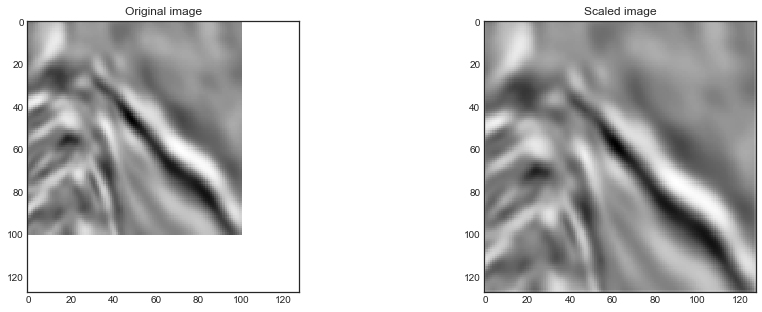

In [429]:
tmp_img = np.zeros((new_size, new_size), dtype=train_full.images[train_id[25]].dtype)
tmp_img[:image_size[0], :image_size[1]] = train_full.images[train_id[25]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(train_x[25].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

Looks like the splitting and scaling has worked perfectly.

## Augmenting the Data

I will also augment the data to horizontally flip the images and add these to the current images doubling our data set as the nature of the images and their non-uniformity allows us to do this without risking overfitting.

In [439]:
train_x = np.append(train_x, [np.fliplr(img) for img in train_x], axis=0)
train_y = np.append(train_y, [np.fliplr(img) for img in train_y], axis=0)

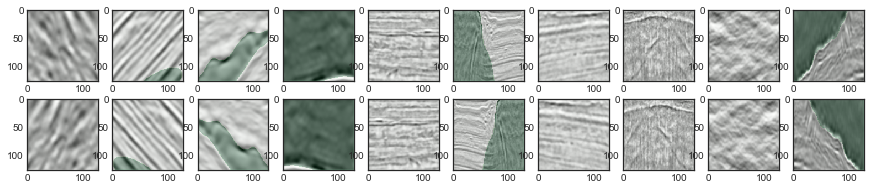

In [441]:
fig, axs = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axs[0][i].imshow(train_x[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(train_y[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(train_x[int(len(train_x)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(train_y[int(len(train_x)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)

## Building the Model

Now I need to build the Unet model, I'm going to make a function for this so that I can experiment with different amounts of channels. Because of how Unets work I am limited in the number of layers I can create based on the image size.

In [434]:
def build_model(input_layer, base_channels):
    dropout = 0.25
    kernel = (3, 3)
    stride = (2, 2)
    # Image size: 128 to 64
    conv1 = Conv2D(base_channels, kernel, activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(base_channels, kernel, activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout)(pool1)
    
    # Image size: 64 to 32
    conv2 = Conv2D(base_channels * 2, kernel, activation="relu", padding="same")(pool1)
    conv2 = Conv2D(base_channels * 2, kernel, activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout*2)(pool2)
    
    # Image size: 32 to 16
    conv3 = Conv2D(base_channels * 4, kernel, activation="relu", padding="same")(pool2)
    conv3 = Conv2D(base_channels * 4, kernel, activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout*2)(pool3)
    
    # Image size: 16 to 8
    conv4 = Conv2D(base_channels * 8, kernel, activation="relu", padding="same")(pool3)
    conv4 = Conv2D(base_channels * 8, kernel, activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout*2)(pool4)
    
    # Midway point
    conv_mid = Conv2D(base_channels * 16, kernel, activation="relu", padding="same")(pool4)
    conv_mid = Conv2D(base_channels * 16, kernel, activation="relu", padding="same")(conv_mid)
    
    # Now we mirror the above layers and begin increasing the image size using Conv2DTranspose layers
    # Image size: 8 to 16
    trans_conv4 = Conv2DTranspose(base_channels * 8, kernel, strides=stride, padding="same")(conv_mid)
    uconv4 = concatenate([trans_conv4, conv4])
    uconv4 = Dropout(dropout * 2)(uconv4)
    uconv4 = Conv2D(base_channels * 8, kernel, activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(base_channels * 8, kernel, activation="relu", padding="same")(uconv4)
    
    # Image size: 16 to 32
    trans_conv3 = Conv2DTranspose(base_channels * 4, kernel, strides=stride, padding="same")(uconv4)
    uconv3 = concatenate([trans_conv3, conv3])
    uconv3 = Dropout(dropout * 2)(uconv3)
    uconv3 = Conv2D(base_channels * 4, kernel, activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(base_channels * 4, kernel, activation="relu", padding="same")(uconv3)
    
    # Image size: 32 to 64
    trans_conv2 = Conv2DTranspose(base_channels * 2, kernel, strides=stride, padding="same")(uconv3)
    uconv2 = concatenate([trans_conv2, conv2])
    uconv2 = Dropout(dropout * 2)(uconv2)
    uconv2 = Conv2D(base_channels * 2, kernel, activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(base_channels * 2, kernel, activation="relu", padding="same")(uconv2)
    
    # Image size: 64 to 128
    trans_conv1 = Conv2DTranspose(base_channels, kernel, strides=stride, padding="same")(uconv2)
    uconv1 = concatenate([trans_conv1, conv1])
    uconv1 = Dropout(dropout)(uconv1)
    uconv1 = Conv2D(base_channels, kernel, activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(base_channels, kernel, activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [435]:
input_layer = Input((new_size, new_size, 1))
output_layer = build_model(input_layer, 16)

In [436]:
model = Model(input_layer, output_layer)

In [437]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [438]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_4[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
dropout_1 

## Training the Model

Now I can begin training the model, I am unsure what parameters I will start out with but I will experiment with each to find what works best.

I know that my setup will be a large number of epochs so that I can use early stopping to find the best possible model. I will store the best model in a seperate file for later use.

In [443]:
early_stop = EarlyStopping(patience=5, verbose=1)
model_check = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
learning_rate_control = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
epochs = 10
batch_size = 32

results = model.fit(train_x, train_y,
                    validation_data=[val_x, val_y],
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stop, model_check, learning_rate_control])

Train on 6356 samples, validate on 795 samples
Epoch 1/10
 384/6356 [>.............................] - ETA: 10:02 - loss: 0.6156 - acc: 0.7251

KeyboardInterrupt: 